# Introduction and Metric
Nobody likes inching along through traffic, getting jostled around by speed bumps, or slowing to a stop every few seconds. Consequently, in our search for the best Pittsburgh neighborhood, we—the Traffic Trio—came to the conclusion that a neighborhood can only be as good as its roads. After all, while an uneventful night in a boring town can still be livened up with a joyride, an otherwise pleasant neighborhood can be ruined by one bad intersection.

To measure the driving quality of a neighborhood, we came up with three submetrics:
* Average driving speed
* Speed bump frequency
* Stop sign density  

Although there are many factors that may influence your enjoyment behind the wheel, we chose these three because they all influence your ability to go fast—isn't that what everyone cares about the most?

## Submetric 1: Average Driving Speed

First, let's get straight to the point with average driving speed. We can start our analysis by importing the necessary libraries, reading in the relevant CSV, and initializing some dictionaries.

In [17]:
import pandas as pd
import csv
from matplotlib import pyplot
%matplotlib inline

# load data
with open("speeds.csv") as f:
    dataset = [row for row in csv.reader(f)]
neighSpeeds = {}
neighCount = {}
neighAveSpeed = {}

pd.read_csv("speeds.csv").head()

,id,device_id,record_oid,count_start_date,count_end_date,average_daily_car_traffic,average_daily_bike_traffic,counter_number,counter_type,speed_limit,...,longitude,latitude,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone
0,1011743669,85,1.445865e+09,2019-04-18,2019-04-26,4949.0,NaN,6,StatTrak,25.0,...,-79.967772,40.455733,Polish Hill,7.0,6.0,42003060500,6.0,6.0,2.0,2-6
1,1026101993,140,1.121444e+09,2019-01-24,NaN,NaN,NaN,NaN,Intersection Study,NaN,...,-79.952249,40.466157,Central Lawrenceville,7.0,9.0,42003090200,2.0,9.0,2.0,3-6
2,1032382575,11,1.539893e+09,2018-08-28,2018-09-04,NaN,NaN,NaN,NaN,35.0,...,-80.076469,40.460717,Windgap,2.0,28.0,42003563000,5.0,28.0,6.0,1-16
3,103627606,9,7.341951e+08,2018-07-17,2018-08-01,2741.0,NaN,NaN,StatTrak,25.0,...,-79.914335,40.437379,Squirrel Hill South,5.0,14.0,42003140800,3.0,14.0,4.0,2-18
4,1039546167,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-80.019211,40.490794,Perry North,1.0,26.0,42003260200,1.0,26.0,1.0,1-15


Then, by looping through the dataset, we can add each entry's neighborhoods and recorded median speed to their respective dictionary, with `if-else` statements to seperate the entries into ones that are already in the dictionary and those who are not. The `neighSpeeds` and `neighCount` dictionaries will keep track of all the median speeds added together and how many speeds there are, respectively, so we can find the average of the median speeds in every entry.

In [18]:
for row in dataset[1:]:
    if row[11] != '':
        if row[17] in neighSpeeds:
            neighSpeeds[row[17]] = float(neighSpeeds[row[17]]) + float(row[11])
            neighCount[row[17]] = int(neighCount[row[17]])+1
        else:
            neighSpeeds[row[17]] = float(row[11])
            neighCount[row[17]] = 1

keys = list(neighSpeeds.keys())
for i in range(len(neighSpeeds)):
    key = keys[i]
    neighAveSpeed[key] = float(neighSpeeds[key])/float(neighCount[key])

Finally, we can plot the results to look at the average speeds.

Text(0, 0.5, 'Speed (mph)')

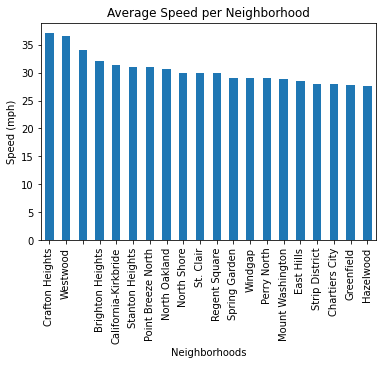

In [19]:
neighAveSpeed_series = pd.Series(neighAveSpeed, name = "Speed")
neighAveSpeed_series.sort_values(ascending=False)[:20].plot.bar()
pyplot.title('Average Speed per Neighborhood')
pyplot.xlabel('Neighborhoods')
pyplot.ylabel('Speed (mph)')

Most of the neighborhoods are in a similar range, but there are a few clear winners. Crafton Heights and Westwood came out on top in this round by impressively crossing the 35mph threshold!

## Submetric 2: Speed Bump Frequency
Next, we can steer clear of unpleasant surprises by minimizing the odds of hitting a speed bump. To find the neighborhoods with the fewest speed bumps, we'll first need to read in a CSV keeping track of their locations.

In [20]:
speed_humps = pd.read_csv('speed_humps.csv')
speed_humps.head()

,id,hump_id,locator_address_number,locator_street,pavement,speed_hump_material,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,430808404,1,4337.0,Saline St,9257,Asphalt,Squirrel Hill South,5,14,42003141400,3,14,4,2-15,40.419835,-79.926062
1,1520886592,2,NaN,Summerset Dr,15346,NaN,Squirrel Hill South,5,14,42003141400,3,14,4,2-20,40.425040,-79.912040
2,858537521,3,511.0,Gold Way,1755,Asphalt,North Oakland,6,5,42003562000,3,5,4,2-23,40.456746,-79.954521
3,297775878,4,547.0,Gold Way,1755,Asphalt,North Oakland,6,5,42003562000,3,5,4,2-23,40.457333,-79.954899
4,1061197751,5,593.0,Gold Way,1755,Asphalt,North Oakland,6,5,42003562000,3,5,4,2-23,40.458061,-79.955355


The next step is to figure out how many speed bumps are in each neighborhood, which can be done with the `groupby` function in combination with the `count` aggregate function. While most of the speed bumps in this dataset have a material of "Asphalt," some are listed with a "None" material, which effectively aren't speed bumps and therefore need to be filtered out. Fortunately, Pandas does this automatically by recognizing the `None` keyword.

In [21]:
nbhd_counts = speed_humps.groupby(['neighborhood'])['speed_hump_material'].count().reset_index(name='speed_bumps')

Now that we've calculated the total number of speed bumps in each neighborhood, we need to figure out the size of each neighborhood to assign appropriate weights. After all, the driving quality of a neighborhood is dependent on its speed bump *frequency*, not just the overall quantity. To do this, we'll be using a different CSV containing the square footage of each neighborhood and merging it with `nbhd_counts` before storing the calculated densities in a dictionary.

In [22]:
nbhds = pd.read_csv('neighborhoods.csv').loc[:,['hood','sqmiles']]
merged_nbhds = pd.merge(nbhd_counts,nbhds,left_on='neighborhood',right_on='hood')
speed_bump_density = {}
for index, row in merged_nbhds.iterrows():
    if row['sqmiles']:
        speed_bump_density[row['neighborhood']] = row['speed_bumps']/row['sqmiles']
        
nbhds.head()

,hood,sqmiles
0,Point Breeze North,0.286
1,Squirrel Hill North,1.222
2,Garfield,0.457
3,Bedford Dwellings,0.179
4,Knoxville,0.302


Finally, we can visualize the frequencies (speed bumps per square mile) for each neighborhood by converting the dictionary to a series and plotting it as a bar graph.

Text(0, 0.5, 'Speed Bumps Per Square Mile')

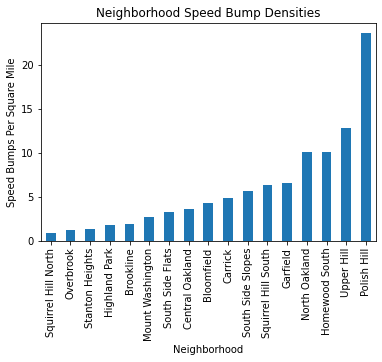

In [23]:
speed_bump_density_series = pd.Series(speed_bump_density)
bar_graph = speed_bump_density_series.sort_values().plot(kind='bar')
pyplot.title('Neighborhood Speed Bump Densities')
pyplot.xlabel('Neighborhood')
pyplot.ylabel('Speed Bumps Per Square Mile')

This graph is fortunately more revealing than the previous one, with a handful of neighborhoods like Squirrel Hill North, Overbrook, and Stanton Heights pulling far ahead of the rest and some clear losers—especially Polish Hill—falling well behind.

## Submetric 3: Stop Sign Density
While they may not send your car flying, stop signs can still be annoying when you're in a hurry. Who wants to stop every few seconds? Definitely not us. To figure out which neighborhoods have the fewest stop signs per square mile, we'll first need to read in the necessary CSVs and initialize some dictionaries to keep track of everything.

In [24]:
df = pd.read_csv("traffic_signs.csv")
df_sizes = pd.read_csv("neighborhoods.csv")
signs = {}  # neighborhood: # of stop signs
sign_density = {}  # neighborhood: density of stop signs

df.head()

,id,mutcd_code,address_number,street,city,mounting_fixture,date_installed,description,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1673225887,R1-1,900,California Ave,Pittsburgh,Wood Pole,NaN,Stop,California-Kirkbride,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-9,40.459325,-80.019057
1,668379452,R1-1,107,Glenbury St,Pittsburgh,Channel,NaN,Stop,Overbrook,4.0,32.0,4.200332e+10,5.0,32.0,3.0,4-25,40.386955,-80.002161
2,174468442,R1-1,5325,Forbes Ave,Pittsburgh,Wood Pole,NaN,Stop,Squirrel Hill North,8.0,14.0,4.200314e+10,3.0,14.0,4.0,2-8,40.439828,-79.934814
3,1517107112,R1-1,1437,N St Clair St,Pittsburgh,Channel,NaN,Stop,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,3-9,40.478685,-79.919270
4,1374142598,WF,228,Isabella St,Pittsburgh,Metal Pole,1995-02-14,Wayfinding Signage,North Shore,1.0,22.0,4.200356e+10,6.0,22.0,1.0,1-20,40.448482,-80.000671


Next, we can iterate through the DataFrame to calculate the number of stop signs per neighborhood. For every row of the DataFrame, if the sign is a stop sign, we'll increment the corresponding neighborhood's value in the dictionary or add the neighborhood if needed.

In [25]:
for index, row in df.iterrows():
    if row["description"] == "Stop":
        if row["neighborhood"] in signs:
            signs[row["neighborhood"]] += 1
        else:
            signs[row["neighborhood"]] = 1

Lastly, we can calculate the density of stop signs per neighborhood using the stop sign counts from before and the size of each neighborhood in square miles from the "neighborhoods" dataset.

In [26]:
for index, row in df_sizes.iterrows():
    if row["sqmiles"] and row["hood"] in signs:
        sign_density[row["hood"]] = signs[row["hood"]]/row["sqmiles"]

This data can be represented by a bar graph, showing the 20 neighborhoods with the least amount of stop signs per square mile.

Text(0, 0.5, '# of Stop Signs per Square Mile')

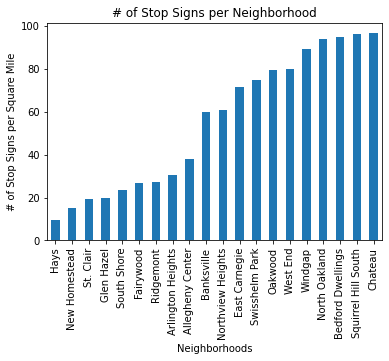

In [27]:
series = pd.Series(sign_density)
bar_graph = series.sort_values(ascending=True)[:20].plot(kind='bar')
pyplot.title('# of Stop Signs per Neighborhood')
pyplot.xlabel('Neighborhoods')
pyplot.ylabel('# of Stop Signs per Square Mile')

This submetric gives a good lead to a few neighborhoods like Hays and New Homestead and generally favors everything before Banksville, at which point the stop sign density increases dramatically.

# The Best Neighborhood
Oddly enough, there were some pretty significant gaps between the findings of each submetric. Average driving speed and speed bump frequency at least had *some* neighborhoods in common, but stop sign density featured an almost entirely different spread. This naturally makes it difficult to land on a single best neighborhood, but ultimately, Stanton Heights seems to come out on top. Despite not even appearing in the top 20 neighborhoods for stop sign density, it's in the top 5 for average driving speeds and the top 3 for speed bump frequency, which makes it more consistently high-ranking than any other neighborhood.

# Conclusion
**Owen:** Before this project, I hadn't even *heard* of Stanton Heights. My personal favorite neighborhood is Downtown. It's lively at night and has everything from jazz clubs to a state park, and if you can find your way onto a rooftop, the views are better than Mount Washington.

**Greg:** My favorite neighborhood is South Oakland, but it makes sense why it didn't rank in the top 20 of any of our metrics. South Oakland is a nightmare to drive in with all of the stop signs, intersections, one-ways, and people walking around, so if I'm just going for a drive I prefer to go to a neighborhood similar to Stanton Heights.

**Yu:** I'm completely new to Pittsburgh, and I haven't drove in any of the neighborhoods in Pittsburgh at all. However, just walking around I can see that certain streets are a nightmare to navigate and drive through. If I were to pick a favorite neighborhood, it would be Fairywood.